# EDA and Feature Engineering

This notebook provides examples of using AEP Query Service for two important activities in any machine learninig project: exploratory data analysis, and building features from raw data in AEP.  We will first use Query Service interactively with our synthetic Experience Events dataset to understand the data and identify potential features we can build for the subscription propensity model we are building. Then we will progressively build a query template we can use the Query Service to transform the events data into dataset of features we will use for training our propensity model.

- [Setup](#setup)
- [1. Basic queries](#1-basic-queries)
- [2. EDA with interactive queries](#2-exploratory-data-analysis-with-query-service)
- [3. Featurization with Query Service](#2-featurization-with-query-service)

# Setup

This notebook requires some configuration parameters to properly authenticate to your Adobe Experience Platform instance. Please follow the instructions in the [**README**](../README.md) to gather the necessary configuration parameters and prepare the [config.ini](../conf/config.ini) file with the specific values for your environment.

The next cell will be looking for your configuration file under your **ADOBE_HOME** path to fetch the configuration values that will be used for this notebook. If necessary, modify the `config_path` and/or the `config_file` name to reflect the location of your config file. 

In [2]:
import os
from configparser import ConfigParser
import aepp

os.environ["ADOBE_HOME"] = os.path.dirname(os.getcwd())

if "ADOBE_HOME" not in os.environ:
    raise Exception("ADOBE_HOME environment variable needs to be set.")

config = ConfigParser()
config_file = "aemassets_config.ini"
#config_path = os.path.join(os.environ["ADOBE_HOME"], "conf", config_file)
config_path = f"/Users/jeremypage/Library/CloudStorage/OneDrive-Adobe/Projects/Cloud ML/environments/{config_file}"

if not os.path.exists(config_path):
    raise Exception(f"Looking for configuration under {config_path} but config not found, please verify path")

config.read(config_path)

aepp.configure(
  org_id=config.get("Platform", "ims_org_id"),
  tech_id=config.get("Platform", "tech_acct_id"), 
  secret=config.get("Platform", "client_secret"),
  scopes=config.get("Platform", "scopes"),
  client_id=config.get("Platform", "client_id"),
  environment=config.get("Platform", "environment"),
  sandbox=config.get("Platform", "sandbox_name")
)

To ensure uniqueness of resources created as part of this notebook, we are using your local username to include in each of the resource titles to avoid conflicts.

In [3]:
import re
username = os.getlogin()
unique_id = s = re.sub("[^0-9a-zA-Z]+", "_", username)

Helper function to generate link to resource in the UI:

In [5]:
def get_ui_link(tenant_id, resource_type, resource_id):
    environment = config.get("Platform", "environment")
    sandbox_name = config.get("Platform", "sandbox_name")
    if environment == "prod":
        prefix = f"https://experience.adobe.com"
    else:
        prefix = f"https://experience-{environment}.adobe.com"
    return f"{prefix}/#/@{tenant_id}/sname:{sandbox_name}/platform/{resource_type}/{resource_id}"

# 1. Basic queries

In this section we will illustrate of the basics of using Query Service interactively: 
- Establish an interactive session with Query Service
- Discover the schema of the data and examine a few rows
- Options for querying nested data

## 1.1 Start an interactive session with Query Service

Every dataset ID in the Adobe Experience Platform is tied to a table name in Query Service world. We can easily get the table name by doing a lookup on the dataset ID and extracting the table name from the dataset tags:

In [7]:
from aepp import catalog

cat_conn = catalog.Catalog()

dataset_id = config.get('Data', 'events_dataset')
dataset_info = cat_conn.getDataSet(dataset_id)
table_name = dataset_info[dataset_id]["tags"]["adobe/pqs/table"][0]
table_name

'synthetic_data_experience_event_dataset_created_by_jeremypage'

When you set the connection to the query service object you'll setup a connection to the actual table you need to connect to, this will be faster and use up less resources from the query service API

In [16]:
from aepp import queryservice

qs_conn = queryservice.QueryService().connection()
qs_conn["dbname"] = f"{cat_conn.sandbox}:{table_name}"
qs_cursor = queryservice.InteractiveQuery2(qs_conn)

## 1.2 Query the dataset

We can use the interactive session we just created to issue ad hoc queries to Query Service. As an example here we simply select all the fields in our synthetic data table.

In [10]:
sample_experience_event_query = f'''SELECT * FROM {table_name} LIMIT 5'''
qs_cursor.query(sample_experience_event_query)

,timestamp,_aemonacpprodcampaign,_id,directMarketing,eventMergeId,eventType,producedBy,web
0,2023-08-15 23:53:33.452,(42494196423661076584100998762229216271),249cceec-3270-44ba-8bfe-2772ce371344,"(NULL,""(1.0)"",344,TkfV0SqAbw,576b24e6-8088-46e...",None,directMarketing.emailSent,databricks-synthetic,None
1,2023-08-15 23:46:21.452,(25927867777584609860411956440517583125),9052cb99-aff6-4110-b7cd-6f7b8060753c,None,None,advertising.impressions,databricks-synthetic,"(""(http://www.qtHKS.com,""(0.0)"",k30xq,ptjxF,ex..."
2,2023-08-15 22:51:38.452,(18853065413958237026739881787339921876),9f7bf253-e4ca-4dec-878f-fd0542b2ce40,"(NULL,""(1.0)"",1165,tijl5VZLgT,db3c06c3-c249-42...",None,directMarketing.emailSent,databricks-synthetic,None
3,2023-08-15 22:57:58.452,(47480256292172459734263315340204454026),dfd38ac4-d440-47d6-a53e-74bbd1e260b0,None,None,advertising.impressions,databricks-synthetic,"(""(http://www.SMGXM.com,""(0.0)"",oeuvL,6IYxi,ot..."
4,2023-08-15 22:57:52.452,(45388667075294606412802689095497963421),3641f4a4-9ef5-49fe-b2f7-061db0bf786c,None,None,web.webpagedetails.pageViews,databricks-synthetic,"(""(http://www.l6srs.com,""(0.0)"",w6NG7,9cszP,do..."


## 1.3 Querying nested data

Let's sample some of the fields in our dataset - we have different types, some are timestamps, some are just primitives like strings, and then some are complex nested XDM structures. Let's see what we get when we query it as-is: 

In [12]:
schema_query= f'''SELECT directMarketing, _id, eventType, timestamp FROM {table_name} LIMIT 5'''
df = qs_cursor.query(schema_query, output="dataframe")
df.head()

,directMarketing,_id,eventType,timestamp
0,"(NULL,""(1.0)"",344,TkfV0SqAbw,576b24e6-8088-46e...",249cceec-3270-44ba-8bfe-2772ce371344,directMarketing.emailSent,2023-08-15 23:53:33.452
1,None,9052cb99-aff6-4110-b7cd-6f7b8060753c,advertising.impressions,2023-08-15 23:46:21.452
2,"(NULL,""(1.0)"",1165,tijl5VZLgT,db3c06c3-c249-42...",9f7bf253-e4ca-4dec-878f-fd0542b2ce40,directMarketing.emailSent,2023-08-15 22:51:38.452
3,None,dfd38ac4-d440-47d6-a53e-74bbd1e260b0,advertising.impressions,2023-08-15 22:57:58.452
4,None,3641f4a4-9ef5-49fe-b2f7-061db0bf786c,web.webpagedetails.pageViews,2023-08-15 22:57:52.452


As we can see when looking at the complex nested field, it's pretty hard to make sense of what this data is and the underlying structure:

In [13]:
df["directMarketing"].iloc[0]

'(NULL,"(1.0)",344,TkfV0SqAbw,576b24e6-8088-46ed-89e9-bd18847e7068,NULL,NULL,"(1.0)")'

Now let's run the same query again but with a twist: we can set the `auto_to_json` flag to be true - this configuration ensures that complex structures are automatically converted into a json form so that the field names can be queried.

In [14]:
schema_query= f"""
SET auto_to_json=true; 

SELECT directMarketing, _id, eventType, timestamp 
FROM {table_name} 
LIMIT 5"""
df = qs_cursor.query(schema_query, output="dataframe")
df

,directMarketing,_id,eventType,timestamp
0,"{""emailDelivered"":{""value"":1.0},""emailVisitorI...",249cceec-3270-44ba-8bfe-2772ce371344,directMarketing.emailSent,2023-08-15 23:53:33.452
1,None,9052cb99-aff6-4110-b7cd-6f7b8060753c,advertising.impressions,2023-08-15 23:46:21.452
2,"{""emailDelivered"":{""value"":1.0},""emailVisitorI...",9f7bf253-e4ca-4dec-878f-fd0542b2ce40,directMarketing.emailSent,2023-08-15 22:51:38.452
3,None,dfd38ac4-d440-47d6-a53e-74bbd1e260b0,advertising.impressions,2023-08-15 22:57:58.452
4,None,3641f4a4-9ef5-49fe-b2f7-061db0bf786c,web.webpagedetails.pageViews,2023-08-15 22:57:52.452


As we can see, the data is now much easier to digest, and we can see clearly the underlying structure along with the different field names.

In [ ]:
df["directMarketing"].iloc[0]

'{"emailDelivered":{"value":1.0},"emailVisitorID":"8683","hashedEmail":"HML2Y0NiNi","messageID":"a228132b-de0c-47c8-8a2f-fd764404b07f","sends":{"value":1.0}}'

In [ ]:
import json

json.loads(df["directMarketing"].iloc[0])

{'emailDelivered': {'value': 1.0},
 'emailVisitorID': '8683',
 'hashedEmail': 'HML2Y0NiNi',
 'messageID': 'a228132b-de0c-47c8-8a2f-fd764404b07f',
 'sends': {'value': 1.0}}

# 2. Exploratory Data Analysis with Query Service

In this section we will use interactive queries to analyze our synthetic Experience Events dataset in AEP: 
- Compute basic statistics from the dataset
- Examine correlations among features to inform feature building for the propensity model

## 2.1 Manually get some basic statistics

Let's look at the number of rows, number of profiles in our synthetic dataset as an example of basic computations that can be done with Query Service:

In [18]:
basic_statistics_query = f"""
SELECT
    COUNT(_id) as "totalRows",  
    COUNT(DISTINCT _id) as "distinctUsers" 
FROM {table_name}"""
df = qs_cursor.query(basic_statistics_query, output="dataframe")
df

,totalRows,distinctUsers
0,1064218,1064218


## 2.2 Create a sampled version of the table

If our dataset is too big, or we simply don't need to get exact numbers for our queries, we can use the [sampling functionality](https://experienceleague.adobe.com/docs/experience-platform/query/sql/dataset-samples.html?lang=en) available in Query Service. This happens in multiple steps:
- First we have to **analyze** the table to create an actual sample with a specific sampling ratio.
- Then we can query the actual sample created which will automatically extrapolate the numbers to the full dataset.

As an example below, this is how we start by analyzing the table and creating a 5% sample:

In [19]:
# A sampling rate of 10 is 100% in Query Service, so for 5% we have to use 0.5
sampling_rate = 0.5

In [20]:
analyze_table_query=f"""
SET aqp=true; 

ANALYZE TABLE {table_name} TABLESAMPLE SAMPLERATE {sampling_rate}"""
qs_cursor.query(analyze_table_query, output="raw")

<cursor object at 0x12469ce50; closed: 0>

If we want to see all the different samples available for our table, we can use the `sample_meta` function which will have an entry for each sample pointing to that sample's dataset ID and table name as well as the recorded sampling ratio.

In [21]:
sampled_version_of_table_query = f'''SELECT sample_meta('{table_name}')'''

df_samples = qs_cursor.query(sampled_version_of_table_query, output="dataframe")
df_samples

,sample_table_name,sample_dataset_id,parent_dataset_id,sample_type,sampling_rate,filter_condition_on_source_dataset,sample_num_rows,created
0,synthetic_data_experience_event_dataset_create...,654b35ce132c1f28d5d3be76,654b20fe82b01e28d381630a,uniform,0.5,,5272,08/11/2023 07:16:30


So now let's compare what happens when we run the same query on both the original table, and our 5% sample. We're using a very simple query to just do a `COUNT` to compare both the accuracy of the result, and also how much faster it is.

In [22]:
%%time
count_query=f'''SELECT count(*) from {table_name}'''
df = qs_cursor.query(count_query, output="dataframe")
df

CPU times: user 2.19 ms, sys: 2.39 ms, total: 4.58 ms
Wall time: 2.52 s


,count(1)
0,1064218


To query the sample we get the sampling table name from the metadata above, and then query it directly and multiply the results by the sampling ratio to get an estimate.

In [23]:
sample_table_name = df_samples[df_samples["sampling_rate"] == sampling_rate]["sample_table_name"].iloc[0]
sample_table_name

'synthetic_data_experience_event_dataset_created_by_sample_0_5'

In [24]:
%%time
count_query=f'''SELECT count(*) as cnt from {sample_table_name}'''
df = qs_cursor.query(count_query, output="dataframe")
approx_count = df["cnt"].iloc[0] / (sampling_rate / 100)
print(f"Approximate count: {approx_count} using {sampling_rate *10}% sample")

Approximate count: 1054400.0 using 5.0% sample
CPU times: user 2.18 ms, sys: 2.51 ms, total: 4.69 ms
Wall time: 2.49 s


<div class="alert alert-block alert-warning">
<b>Note:</b>
    
You can also query the latest sample from that dataset by using `SELECT * from {table_name} WITHAPPROXIMATE` however it is not advised to do aggregation queries or joins with that since this is only a uniform random sample.
</div>

We can see that the results are pretty accurate <1% error, and also the runtime is reduced by at least 20%, so using samples are a good choice for featurization data if we have a ML model that is not necessarily data-hungry.

## 2.3 Email Funnel Analysis

Let's look at the funnel of how many users actually fill out the webForm. A funnel analysis is a method of understanding the steps required to reach an outcome on a website and how many users get through each of those steps.

In [25]:
simple_funnel_analysis_query = f'''SELECT eventType, COUNT(DISTINCT _id) as "distinctUsers",COUNT(_id) as "distinctEvents" FROM {table_name} GROUP BY eventType ORDER BY distinctUsers DESC'''
funnel_df = qs_cursor.query(simple_funnel_analysis_query, output="dataframe")
funnel_df

,eventType,distinctUsers,distinctEvents
0,directMarketing.emailSent,500694,500694
1,directMarketing.emailOpened,197690,197690
2,web.webpagedetails.pageViews,100165,100165
3,advertising.impressions,100004,100004
4,directMarketing.emailClicked,42967,42967
5,commerce.productViews,31659,31659
6,web.webinteraction.linkClicks,31332,31332
7,decisioning.propositionDisplay,31194,31194
8,web.formFilledOut,14827,14827
9,advertising.clicks,6354,6354


Here, we launch a query to get number of users in each phase

In [26]:
import plotly.express as px

email_funnel_events = ["directMarketing.emailSent", "directMarketing.emailOpened", "directMarketing.emailClicked", "web.formFilledOut"]
email_funnel_df = funnel_df[funnel_df["eventType"].isin(email_funnel_events)]

fig = px.funnel(email_funnel_df, y='eventType', x='distinctUsers')
fig.show()

## 2.4 Event correlation
Now, we analyze the correlation between various types of events. 

We'll look for which events predict the `web.formFilledOut` outcome. 

To do this, we must execute a more complex join query.

In [27]:
from aepp import schema
tenant_id = schema.Schema().getTenantId()

event_correlation_query=f'''SELECT  eventType_First, eventType_Later, COUNT(DISTINCT userId) as "distinctUsers"
FROM 
    (
        SELECT a.eventType as eventType_First, 
                b.eventType as eventType_Later, 
                a._{tenant_id}.synth_id as userID 
        FROM {table_name} a
        JOIN {table_name} b
        ON a._{tenant_id}.synth_id = b._{tenant_id}.synth_id
        WHERE a.timestamp <= b.timestamp
    )
GROUP BY eventType_First, eventType_Later
ORDER BY distinctUsers DESC'''
event_correlation_df = qs_cursor.query(event_correlation_query, output="dataframe")
event_correlation_df

,eventType_First,eventType_Later,distinctUsers
0,directMarketing.emailSent,directMarketing.emailSent,99340
1,directMarketing.emailOpened,directMarketing.emailOpened,85775
2,directMarketing.emailSent,directMarketing.emailOpened,85775
3,advertising.impressions,advertising.impressions,63179
4,web.webpagedetails.pageViews,web.webpagedetails.pageViews,63075
...,...,...,...
164,commerce.purchases,decisioning.propositionDisplay,34
165,commerce.purchases,web.webinteraction.linkClicks,23
166,commerce.purchases,directMarketing.emailClicked,21
167,commerce.purchases,decisioning.propositionInteract,5


Now we join the results of this correlation to obtain a coocurrence matrix which we can then display to get a visual feel of which events are likely to be occurring together.

In [28]:
coocc_matrix = event_correlation_df
individual_counts = funnel_df
cocc_with_individual = coocc_matrix.merge(individual_counts, left_on="eventType_First", right_on="eventType")
cocc_with_individual["probability"] = cocc_with_individual["distinctUsers_x"]/ cocc_with_individual["distinctUsers_y"]

<Axes: xlabel='eventType_Later', ylabel='eventType_First'>

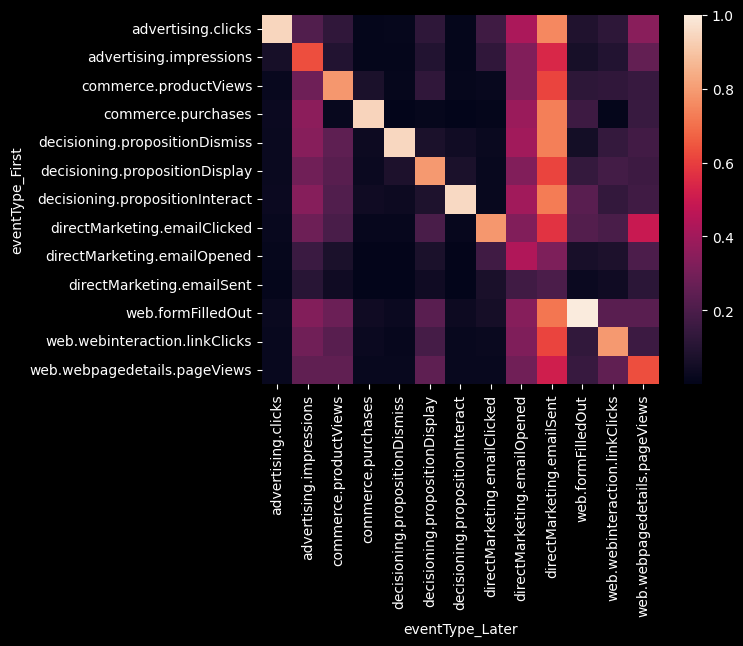

In [29]:
import seaborn as sns

pivoted = cocc_with_individual.pivot(index="eventType_First", columns="eventType_Later", values="probability")
sns.heatmap(pivoted)


## 2.5 A more robust correlation calculation

Let's use an in-built feature of the query service (the Spark functions) to get a better handle of correlations between various eventTypes. We'll use the `corr` function - which computes pearson correlation coefficients between a given eventType, and the target eventType

#### Run on the full dataset

In [30]:
large_correlation_query=f'''
SELECT SUM(webFormsFilled) as webFormsFilled_totalUsers,
       SUM(advertisingClicks) as advertisingClicks_totalUsers,
       SUM(productViews) as productViews_totalUsers,
       SUM(productPurchases) as productPurchases_totalUsers,
       SUM(propositionDismisses) as propositionDismisses_totaUsers,
       SUM(propositionDisplays) as propositionDisplays_totaUsers,
       SUM(propositionInteracts) as propositionInteracts_totalUsers,
       SUM(emailClicks) as emailClicks_totalUsers,
       SUM(emailOpens) as emailOpens_totalUsers,
       SUM(webLinkClicks) as webLinksClicks_totalUsers,
       SUM(webPageViews) as webPageViews_totalusers,
       corr(webFormsFilled, emailOpens) as webForms_EmailOpens,
       corr(webFormsFilled, advertisingClicks) as webForms_advertisingClicks,
       corr(webFormsFilled, productViews) as webForms_productViews,
       corr(webFormsFilled, productPurchases) as webForms_productPurchases,
       corr(webFormsFilled, propositionDismisses) as webForms_propositionDismisses,
       corr(webFormsFilled, propositionInteracts) as webForms_propositionInteracts,
       corr(webFormsFilled, emailClicks) as webForms_emailClicks,
       corr(webFormsFilled, emailOpens) as webForms_emailOpens,
       corr(webFormsFilled, emailSends) as webForms_emailSends,
       corr(webFormsFilled, webLinkClicks) as webForms_webLinkClicks,
       corr(webFormsFilled, webPageViews) as webForms_webPageViews
FROM(
    SELECT _{tenant_id}.synth_id as userID,
            SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) as webFormsFilled,
            SUM(CASE WHEN eventType='advertising.clicks' THEN 1 ELSE 0 END) as advertisingClicks,
            SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) as productViews,
            SUM(CASE WHEN eventType='commerce.productPurchases' THEN 1 ELSE 0 END) as productPurchases,
            SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) as propositionDismisses,
            SUM(CASE WHEN eventType='decisioning.propositionDisplay' THEN 1 ELSE 0 END) as propositionDisplays,
            SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) as propositionInteracts,
            SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) as emailClicks,
            SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) as emailOpens,
            SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) as emailSends,
            SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) as webLinkClicks,
            SUM(CASE WHEN eventType='web.webinteraction.pageViews' THEN 1 ELSE 0 END) as webPageViews
    FROM {table_name}
    GROUP BY userId
)
'''
large_correlation_df = qs_cursor.query(large_correlation_query, output="dataframe")
large_correlation_df

,webFormsFilled_totalUsers,advertisingClicks_totalUsers,productViews_totalUsers,productPurchases_totalUsers,propositionDismisses_totaUsers,propositionDisplays_totaUsers,propositionInteracts_totalUsers,emailClicks_totalUsers,emailOpens_totalUsers,webLinksClicks_totalUsers,...,webForms_advertisingClicks,webForms_productViews,webForms_productPurchases,webForms_propositionDismisses,webForms_propositionInteracts,webForms_emailClicks,webForms_emailOpens,webForms_emailSends,webForms_webLinkClicks,webForms_webPageViews
0,14827,6354,31659,0,2475,31194,2373,42967,197690,31332,...,0.006225,0.223077,None,0.040574,0.129645,0.247286,0.101215,0.028308,0.213603,None


In [31]:
cols = large_correlation_df.columns
corrdf = large_correlation_df[[col for col in cols if ("webForms_"  in col)]].melt()
corrdf["feature"] = corrdf["variable"].apply(lambda x: x.replace("webForms_", ""))
corrdf["pearsonCorrelation"] = corrdf["value"]

corrdf.fillna(0)

,variable,value,feature,pearsonCorrelation
0,webForms_EmailOpens,0.101215,EmailOpens,0.101215
1,webForms_advertisingClicks,0.006225,advertisingClicks,0.006225
2,webForms_productViews,0.223077,productViews,0.223077
3,webForms_productPurchases,0.000000,productPurchases,0.000000
4,webForms_propositionDismisses,0.040574,propositionDismisses,0.040574
5,webForms_propositionInteracts,0.129645,propositionInteracts,0.129645
6,webForms_emailClicks,0.247286,emailClicks,0.247286
7,webForms_emailOpens,0.101215,emailOpens,0.101215
8,webForms_emailSends,0.028308,emailSends,0.028308
9,webForms_webLinkClicks,0.213603,webLinkClicks,0.213603


Let's visualize the results:

/Users/jeremypage/.pyenv/versions/3.11.5/envs/cmle/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jeremypage/.pyenv/versions/3.11.5/envs/cmle/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jeremypage/.pyenv/versions/3.11.5/envs/cmle/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Text(0.5, 1.0, 'Pearson Correlation of Events with the outcome event')

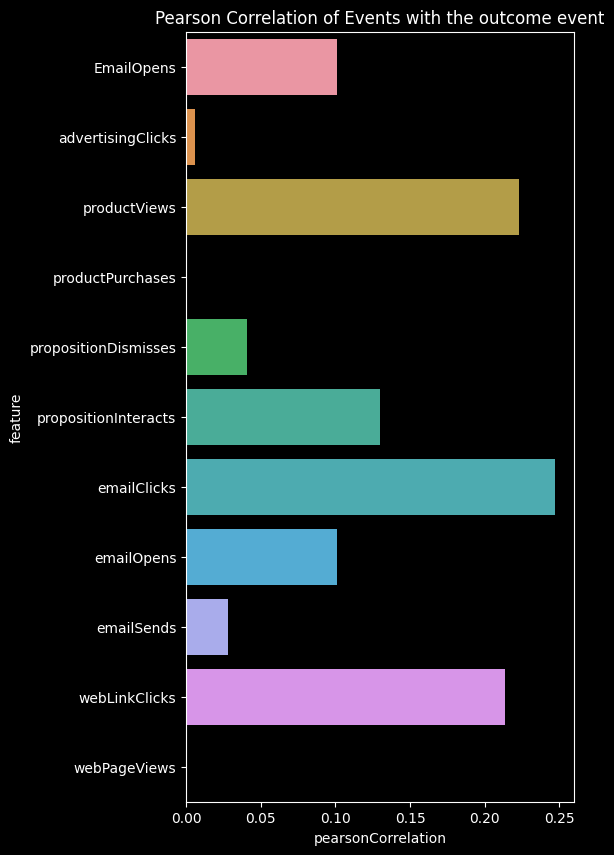

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(data=corrdf.fillna(0), y="feature", x="pearsonCorrelation")
ax.set_title("Pearson Correlation of Events with the outcome event")

<div class="alert alert-block alert-success">
    <b>Conclusion</b>
With this information, we now have a hypothesis on necessary features to use in our model.
We will use the number of these various event types, as well as the recency of each event type as features 
for the model. The next step is to create these "featurized" datasets
</div>

# 3. Build features with Query Service

In this section we will show how you can prepare data for the future goal of consumption by an ML model, and leveraging functionality in the Adobe Experience Platform to generate features at scale and make it available in your choice of cloud storage.

We'll go through several steps:
- **Creating a query** to encapsulate what a good featurized dataset will be.
- **Executing that query** and storing the results.
- **Setting up a flow** to export the results into cloud storage.
- **Executing that flow** to deliver the results.

<div class="alert alert-block alert-warning">
<b>Note:</b> If at any point in this notebook the connection to Query Service is closed, you can refresh it by running the cell below.
</div>

In [33]:
qs_conn = queryservice.QueryService().connection()
qs_conn["dbname"] = f"{cat_conn.sandbox}:{table_name}"
qs_cursor = queryservice.InteractiveQuery2(qs_conn)

## 3.1 Define a featurization query

Let's first define our ML problem scientifically:
- **What kind of problem** are we solving? We'd like to predict whether someone is likely to subscribe or not. We treat that as a binary classification problem, you are either subscribed or you are not.
- What is our **target variable**? Whether a subscription occurred or not for a given user.
- What are our **positive labels**? People who have at least 1 event corresponding to a subscription (marked as `web.formFilledOut`). We will keep a single feature row from the event where they actually subscribed.
- What are our **negative labels**? People who don't have a single event corresponding to a subscription. We will keep a random row to avoid having bias in the data.

Let's put that into practice and start looking at our positive labels:

In [34]:
query_positive_labels = f"""
SELECT *
FROM (
    SELECT
        eventType,
        _{tenant_id}.synth_id as userId,
        SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
            OVER (PARTITION BY _{tenant_id}.synth_id) 
            AS "subscriptionOccurred"
    FROM {table_name}
)
WHERE subscriptionOccurred = 1 AND eventType = 'web.formFilledOut'
"""

df_positive_labels = qs_cursor.query(query_positive_labels, output="dataframe")
print(f"Number of positive classes: {len(df_positive_labels)}")
df_positive_labels.head()

Number of positive classes: 14827


,eventType,userId,subscriptionOccurred
0,web.formFilledOut,01027994177972439148069092698714414382,1
1,web.formFilledOut,01149554820363915324573708359099551093,1
2,web.formFilledOut,01691090386838951573683552317456995170,1
3,web.formFilledOut,01850690113415152017305743272939655573,1
4,web.formFilledOut,02359072124665624903165176879697258522,1


<div class="alert alert-block alert-warning">
<b>Note:</b> 
    
We are using a sub-query because we want to filter on the `subscriptionOccurred` which is defined as part of the query, so it can't be used in a filter condition unless it is in a sub-query.
</div>

Now let's look at our negative labels. Because we just want to retain a random row to avoid bias, we need to introduce randomness into our query:

In [35]:
query_negative_labels = f"""
SELECT *
FROM (
    SELECT
        _{tenant_id}.synth_id as userId,
        SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
            OVER (PARTITION BY _{tenant_id}.synth_id) 
            AS "subscriptionOccurred",
        row_number() OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name}
)
WHERE subscriptionOccurred = 0 AND random_row_number_for_user = 1
"""

df_negative_labels = qs_cursor.query(query_negative_labels, output="dataframe")
print(f"Number of negative classes: {len(df_negative_labels)}")
df_negative_labels.head()

Number of negative classes: 50000


,userId,subscriptionOccurred,random_row_number_for_user
0,01054714817856066632264746967668888198,0,1
1,01117296890525140996735553609305695042,0,1
2,01172121447143590196349410086995740317,0,1
3,01195767814069944741685085653849029220,0,1
4,01198906010679088468352423564573901414,0,1


Putting it all together, we can query both our positive and negative classes with the following query:

In [36]:
query_labels = f"""
SELECT *
FROM (
    SELECT
        eventType,
        _{tenant_id}.synth_id as userId,
        SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
            OVER (PARTITION BY _{tenant_id}.synth_id) 
            AS "subscriptionOccurred",
        row_number() OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name}
)
WHERE (subscriptionOccurred = 1 AND eventType = 'web.formFilledOut') OR (subscriptionOccurred = 0 AND random_row_number_for_user = 1)
"""

df_labels = qs_cursor.query(query_labels, output="dataframe")
print(f"Number of classes: {len(df_labels)}")
df_labels.head()

Number of classes: 50000


,eventType,userId,subscriptionOccurred,random_row_number_for_user
0,web.formFilledOut,01027994177972439148069092698714414382,1,5
1,directMarketing.emailSent,01054714817856066632264746967668888198,0,1
2,directMarketing.emailSent,01117296890525140996735553609305695042,0,1
3,web.formFilledOut,01149554820363915324573708359099551093,1,8
4,directMarketing.emailSent,01172121447143590196349410086995740317,0,1


Now let's think what kind of features make sense for this kind of problem that we would like to eventually feed to an ML model. There's 2 main kinds of features we're interested in:
- **Actionable features**: different actions the user actually took in response to a marketing event.
- **Temporal features**: distribution over time of the actions the user took. This is useful for modeling to capture behavior over time and not just statically at any particular point in time.

We can think of a few simple things that can be derived from this data for the actionable features:
- **Number of emails** that were sent for marketing purposes and received by the user.
- Portion of these emails that were actually **opened**.
- Portion of these emails where the user actually **clicked** on the link.
- **Number of products** that were viewed.
- Number of **propositions that were interacted with**.
- Number of **propositions that were dismissed**.
- Number of **links that were clicked on**.

Regarding the temporal features, we can look at consecutive occurrences between various events. This can be accomplished using the `TIME_BETWEEN_PREVIOUS_MATCH` function. So we take the previous actionable features and look at their temporal distribution:
- Number of minutes between 2 consecutive emails received.
- Number of minutes between 2 consecutive emails opened.
- Number of minutes between 2 consecutive emails where the user actually clicked on the link.
- Number of minutes between 2 consecutive product views.
- Number of minutes between 2 propositions that were interacted with.
- Number of minutes between 2 propositions that were dismissed.
- Number of minutes between 2 links that were clicked on.

Let's put all that in practice and look how we can create these features inside a query:

In [37]:
query_features = f"""
SELECT
    _{tenant_id}.synth_id as userId,
    SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) 
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "emailsReceived",
    SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) 
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "emailsOpened",       
    SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) 
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "emailsClicked",       
    SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) 
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "productsViewed",       
    SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) 
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "propositionInteracts",       
    SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) 
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "propositionDismissed",
    SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) 
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "webLinkClicks" ,
    TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailSent', 'minutes')
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "minutes_since_emailSent",
    TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailOpened', 'minutes')
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "minutes_since_emailOpened",
    TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailClicked', 'minutes')
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "minutes_since_emailClick",
    TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'commerce.productViews', 'minutes')
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "minutes_since_productView",
    TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'decisioning.propositionInteract', 'minutes')
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "minutes_since_propositionInteract",
    TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'propositionDismiss', 'minutes')
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "minutes_since_propositionDismiss",
    TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'web.webinteraction.linkClicks', 'minutes')
       OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
       AS "minutes_since_linkClick"
FROM {table_name}
"""

df_features = qs_cursor.query(query_features, output="dataframe")
df_features.head()

,userId,emailsReceived,emailsOpened,emailsClicked,productsViewed,propositionInteracts,propositionDismissed,webLinkClicks,minutes_since_emailSent,minutes_since_emailOpened,minutes_since_emailClick,minutes_since_productView,minutes_since_propositionInteract,minutes_since_propositionDismiss,minutes_since_linkClick
0,01110877754606198061667040865305511687,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,None,NaN
1,01110877754606198061667040865305511687,1,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,None,NaN
2,01110877754606198061667040865305511687,1,0,0,0,0,0,0,42536.0,NaN,NaN,NaN,NaN,None,NaN
3,01110877754606198061667040865305511687,1,0,0,0,0,0,0,42544.0,NaN,NaN,NaN,NaN,None,NaN
4,01110877754606198061667040865305511687,2,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,None,NaN


At that point we have defined all our features, and we also have our classes cleanly defined, so we can tie everything together in a final query that will represent our training set to be used later on on our ML model.

In [38]:
query_training_set = f"""
SELECT *
FROM (
    SELECT _{tenant_id}.synth_id as userId, 
       eventType,
       timestamp,
       SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id) 
           AS "subscriptionOccurred",
       SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsReceived",
       SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsOpened",       
       SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsClicked",       
       SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "productsViewed",       
       SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionInteracts",       
       SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionDismissed",
       SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "webLinkClicks" ,
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailSent', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailSent",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailOpened', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailOpened",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailClicked', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailClick",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'commerce.productViews', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_productView",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'decisioning.propositionInteract', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionInteract",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'propositionDismiss', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionDismiss",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'web.webinteraction.linkClicks', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_linkClick",
        row_number() OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name} LIMIT 1000
)
WHERE (subscriptionOccurred = 1 AND eventType = 'web.formFilledOut') OR (subscriptionOccurred = 0 AND random_row_number_for_user = 1)
ORDER BY timestamp
"""

df_training_set = qs_cursor.query(query_training_set, output="dataframe")
df_training_set.head()

,userId,eventType,timestamp,subscriptionOccurred,emailsReceived,emailsOpened,emailsClicked,productsViewed,propositionInteracts,propositionDismissed,webLinkClicks,minutes_since_emailSent,minutes_since_emailOpened,minutes_since_emailClick,minutes_since_productView,minutes_since_propositionInteract,minutes_since_propositionDismiss,minutes_since_linkClick,random_row_number_for_user
0,03273194889650762505580714764610664070,directMarketing.emailSent,2023-08-16 02:54:53.261,0,1,0,0,0,0,0,0,0.0,NaN,NaN,NaN,None,None,NaN,1
1,01648313223901462573432769819263750034,directMarketing.emailSent,2023-08-16 03:36:42.607,0,1,0,0,0,0,0,0,0.0,NaN,NaN,NaN,None,None,NaN,1
2,03960113914478677718052489381743423172,web.webpagedetails.pageViews,2023-08-16 09:09:36.296,0,1,1,1,0,0,0,0,228.0,77.0,5.0,NaN,None,None,NaN,1
3,03557977126473094213424402078702899754,advertising.impressions,2023-08-17 00:30:13.012,0,1,0,0,0,0,0,0,904.0,NaN,NaN,NaN,None,None,NaN,1
4,01066367784525869370502097766291450913,directMarketing.emailSent,2023-08-17 14:26:57.607,0,1,0,0,0,0,0,0,0.0,NaN,NaN,NaN,None,None,NaN,1


## 3.2 Generate features incrementally

Now in a typical ML workload you'll want to use incremental data to feed to your model, or data between some specific dates. For that purpose we can use snapshot information that is tracked inside Query Service every time a new batch of data is ingested, using the `history_meta` metadata table. For example, you can access the metadata for each batch of your dataset using the query below:

In [39]:
query_meta = f"""
SELECT * FROM (SELECT history_meta('{table_name}'))
"""

df_meta = qs_cursor.query(query_meta, output="dataframe")
print(f"Total number of snapshots/batches: {len(df_meta)}")
df_meta.head(n=10)

Total number of snapshots/batches: 11


,snapshot_generation,made_current_at,snapshot_id,parent_id,is_current_ancestor,is_current,output_record_count,output_byte_size
0,0,2023-11-08 05:52:06,0,NaN,True,False,0,0
1,1,2023-11-08 05:52:34,1,0.0,True,False,106349,18081182
2,2,2023-11-08 05:53:01,2,1.0,True,False,106990,18184164
3,3,2023-11-08 05:53:36,3,2.0,True,False,105901,18014044
4,4,2023-11-08 05:54:05,4,3.0,True,False,106420,18092385
5,5,2023-11-08 05:54:30,5,4.0,True,False,106576,18108408
6,6,2023-11-08 05:54:53,6,5.0,True,False,106526,18112439
7,7,2023-11-08 05:55:15,7,6.0,True,False,106185,18039495
8,8,2023-11-08 05:55:56,8,7.0,True,False,106443,18104223
9,9,2023-11-08 05:58:02,9,8.0,True,False,106227,18051225


Now let's use that information to transform our featurization query into an incremental version of it. We can use [anonymous blocks](https://experienceleague.adobe.com/docs/experience-platform/query/sql/syntax.html?lang=en#anonymous-block) to create variables used to filter on the snapshots. Anonymous blocks are useful to embed multiple queries at once and do things like defining variables and such. We can then use Query Service's `SNAPSHOT BETWEEN x AND y` functionality to query data incrementally.

In our case because this is the first time generating the features we will look at data between the most recent snapshot and its preceding one (which should correspond to the last batch of data ingested), but this can be extended to query data between any snapshots:

In [40]:
f"""
$$ BEGIN

SET @from_snapshot_id = SELECT parent_id FROM (SELECT history_meta('{table_name}')) WHERE is_current = true;
SET @to_snapshot_id = SELECT snapshot_id FROM (SELECT history_meta('{table_name}')) WHERE is_current = true;

SELECT *
FROM (
    SELECT _{tenant_id}.synth_id as userId, 
       eventType,
       timestamp,
       SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id) 
           AS "subscriptionOccurred",
       SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsReceived",
       SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsOpened",       
       SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsClicked",       
       SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "productsViewed",       
       SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionInteracts",       
       SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionDismissed",
       SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "webLinkClicks" ,
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailSent', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailSent",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailOpened', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailOpened",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailClicked', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailClick",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'commerce.productViews', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_productView",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'decisioning.propositionInteract', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionInteract",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'propositionDismiss', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionDismiss",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'web.webinteraction.linkClicks', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_linkClick",
        row_number() OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name}
    SNAPSHOT BETWEEN @from_snapshot_id AND @to_snapshot_id
)
WHERE (subscriptionOccurred = 1 AND eventType = 'web.formFilledOut') OR (subscriptionOccurred = 0 AND random_row_number_for_user = 1)
ORDER BY timestamp;

EXCEPTION
  WHEN OTHER THEN
    SELECT 'ERROR';

END $$;
"""

'\n$$ BEGIN\n\nSET @from_snapshot_id = SELECT parent_id FROM (SELECT history_meta(\'synthetic_data_experience_event_dataset_created_by_jeremypage\')) WHERE is_current = true;\nSET @to_snapshot_id = SELECT snapshot_id FROM (SELECT history_meta(\'synthetic_data_experience_event_dataset_created_by_jeremypage\')) WHERE is_current = true;\n\nSELECT *\nFROM (\n    SELECT _aemonacpprodcampaign.synth_id as userId, \n       eventType,\n       timestamp,\n       SUM(CASE WHEN eventType=\'web.formFilledOut\' THEN 1 ELSE 0 END) \n           OVER (PARTITION BY _aemonacpprodcampaign.synth_id) \n           AS "subscriptionOccurred",\n       SUM(CASE WHEN eventType=\'directMarketing.emailSent\' THEN 1 ELSE 0 END) \n           OVER (PARTITION BY _aemonacpprodcampaign.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) \n           AS "emailsReceived",\n       SUM(CASE WHEN eventType=\'directMarketing.emailOpened\' THEN 1 ELSE 0 END) \n           OVER (PARTITION BY _aemonacppro

Note that we're not executing it interactively because this anonymous block is actually multiple queries chained together, and there is no simple way to return multiple result sets using PostgreSQL libraries.

To solve that we can executed the query asynchronously and add a `CREATE TABLE x AS` statement at the beginning of our featurization query, to then look in that table. Note that because this is executed asynchronously, it goes into the Query Service scheduler and will take a few minutes to start executing, unlike the code we've been running until now which was synchronous and instant.

In [42]:
import time
import sys

ctas_table_name = f"cmle_example_training_set_incremental_{username}"

query_training_set_incremental = f"""
$$ BEGIN

SET @from_snapshot_id = SELECT parent_id FROM (SELECT history_meta('{table_name}')) WHERE is_current = true;
SET @to_snapshot_id = SELECT snapshot_id FROM (SELECT history_meta('{table_name}')) WHERE is_current = true;

CREATE TABLE {ctas_table_name} AS
SELECT *
FROM (
    SELECT _{tenant_id}.synth_id as userId, 
       eventType,
       timestamp,
       SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id) 
           AS "subscriptionOccurred",
       SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsReceived",
       SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsOpened",       
       SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsClicked",       
       SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "productsViewed",       
       SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionInteracts",       
       SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionDismissed",
       SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "webLinkClicks" ,
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailSent', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailSent",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailOpened', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailOpened",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailClicked', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailClick",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'commerce.productViews', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_productView",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'decisioning.propositionInteract', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionInteract",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'propositionDismiss', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionDismiss",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'web.webinteraction.linkClicks', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_linkClick",
        row_number() OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name}
    SNAPSHOT BETWEEN @from_snapshot_id AND @to_snapshot_id LIMIT 1000
)
WHERE (subscriptionOccurred = 1 AND eventType = 'web.formFilledOut') OR (subscriptionOccurred = 0 AND random_row_number_for_user = 1)
ORDER BY timestamp;

EXCEPTION
  WHEN OTHER THEN
    SELECT 'ERROR';

END $$;
"""

qs = queryservice.QueryService()
query_incremental_res = qs.postQueries(
    name="[CMLE][Week2] Query to generate incremental training data",
    sql=query_training_set_incremental,
    dbname=f"{cat_conn.sandbox}:{table_name}"
)
query_incremental_id = query_incremental_res["id"]
print(f"Query started successfully and got assigned ID {query_incremental_id} - it will take some time to execute")

Query started successfully and got assigned ID d1c9c805-bdba-4aed-a374-4675133de47b - it will take some time to execute


In [43]:
def wait_for_query_completion(query_id):
    while True:
        query_info = qs.getQuery(query_id)
        query_state = query_info["state"]
        if query_state in ["SUCCESS", "FAILED"]:
            break
        print("Query is still in progress, sleeping...")
        time.sleep(60)

    duration_secs = query_info["elapsedTime"] / 1000
    if query_state == "SUCCESS":
        print(f"Query completed successfully in {duration_secs} seconds")
    else:
        print(f"Query failed with the following errors:", file=sys.stderr)
        for error in query_info["errors"]:
            print(f"Error code {error['code']}: {error['message']}", file=sys.stderr)

In [44]:
wait_for_query_completion(query_incremental_id)

Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query completed successfully in 397.009 seconds


<div class="alert alert-block alert-warning">
<b>Note:</b> This should run in less than 10 minutes. If for whatever reason this does not finish in that time frame, it may get stuck creating the batch if the ingestion service is busy ingesting other data in your organization. We advise waiting longer or reaching out to your Adobe contact if this does not complete.
    
The same comment applies to subsequent cells where we use `wait_for_query_completion`.
</div>

This `CREATE TABLE x AS` statement actually does several steps:
- It will create a brand **new dataset** in your Adobe Experience Platform organization and sandbox.
- The **schema** for this dataset will be created ad-hoc to **match the fields** of our featurization query, so there is no need to manually create schemas and fieldgroups for this.

You can verify that by going in the UI at the link below, and making sure it you see the dataset as shown in the screenshot further down. The number of records should correspond to the batch size you used in the previous week since we are querying a single snapshot/batch.

<div class="alert alert-block alert-warning">
<b>Note:</b> Re-executing the same query will fail, because it will try to create a table and not insert into it. We're solving this problem in the next section.
</div>

In [45]:
datasets_res = cat_conn.getDataSets(name=ctas_table_name)
if len(datasets_res) != 1:
    raise Exception(f"Expected a single dataset but got {len(datasets_res)} ones")
ctas_dataset_id = list(datasets_res.keys())[0]
ctas_dataset_link = get_ui_link(tenant_id, "dataset/browse", ctas_dataset_id)
print(f"Dataset available as dataset ID {ctas_dataset_id} under {ctas_dataset_link}")

Dataset available as dataset ID 654b397468fd1c28d3cd2840 under https://experience.adobe.com/#/@aemonacpprodcampaign/sname:laa-e2e/platform/dataset/browse/654b397468fd1c28d3cd2840


![CTAS](./media/CMLE-Notebooks-Week2-CTAS.png)

Now we can just query it to see the structure of the data and verify it matches our query:

In [46]:
query_ctas = f"""
SELECT * FROM {ctas_table_name} LIMIT 10;
"""
qs = queryservice.QueryService()
qs_conn = qs.connection()
qs_conn['dbname']=f'{cat_conn.sandbox}:{ctas_table_name}'
qs_cursor = queryservice.InteractiveQuery2(qs_conn)
df_ctas = qs_cursor.query(query_ctas, output="dataframe")
df_ctas.head()

,userId,eventType,timestamp,subscriptionOccurred,emailsReceived,emailsOpened,emailsClicked,productsViewed,propositionInteracts,propositionDismissed,webLinkClicks,minutes_since_emailSent,minutes_since_emailOpened,minutes_since_emailClick,minutes_since_productView,minutes_since_propositionInteract,minutes_since_propositionDismiss,minutes_since_linkClick,random_row_number_for_user
0,01265589601186984412427218679718749684,directMarketing.emailSent,2023-08-16 22:32:51.021,0,1,0,0,0,0,0,0,0,NaN,NaN,None,None,None,None,1
1,03277429195157756527175174938625550150,directMarketing.emailSent,2023-08-17 07:41:06.021,0,1,0,0,0,0,0,0,0,NaN,NaN,None,None,None,None,1
2,02874284565569821020598376251234705204,directMarketing.emailSent,2023-08-18 21:44:04.021,0,1,0,0,0,0,0,0,0,NaN,NaN,None,None,None,None,1
3,01023357945172267218998293698192856890,directMarketing.emailSent,2023-08-19 00:07:40.021,0,1,0,0,0,0,0,0,0,NaN,NaN,None,None,None,None,1
4,03856377430262329822604292572425877028,directMarketing.emailOpened,2023-08-19 12:49:24.460,0,1,1,0,0,0,0,0,216,0.0,NaN,None,None,None,None,1


## 3.3 Templatize the featurization query

Now we've got a complete featurization query that can also be used to generate features incrementally, but we still want to go further:
- The **snapshot window should be configurable** and easy to change without having to constantly create new queries.
- The query itself should be **stored in a templatized way** so it can be referred to easily.
- The query should be able to **create the table** automatically as well as **inserting into** a pre-existing table.

Query Service has this concept of [templates](https://experienceleague.adobe.com/docs/experience-platform/query/ui/query-templates.html?lang=en) that we will be leveraging in this section to satisfy the requirements mentioned above.

The first step is to make make sure we either create the table if it does not exist, otherwise insert into it. This can be done by checking if the table exists using the `table_exists` function and adding a condition in our anonymous block based on that:

In [47]:
query_training_set_ctas_or_insert = f"""
$$ BEGIN

SET @from_snapshot_id = SELECT parent_id FROM (SELECT history_meta('{table_name}')) WHERE is_current = true;
SET @to_snapshot_id = SELECT snapshot_id FROM (SELECT history_meta('{table_name}')) WHERE is_current = true;
SET @my_table_exists = SELECT table_exists('{ctas_table_name}');

CREATE TABLE IF NOT EXISTS {ctas_table_name} AS
SELECT *
FROM (
    SELECT _{tenant_id}.synth_id as userId, 
       eventType,
       timestamp,
       SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id) 
           AS "subscriptionOccurred",
       SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsReceived",
       SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsOpened",       
       SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsClicked",       
       SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "productsViewed",       
       SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionInteracts",       
       SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionDismissed",
       SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "webLinkClicks" ,
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailSent', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailSent",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailOpened', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailOpened",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailClicked', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailClick",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'commerce.productViews', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_productView",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'decisioning.propositionInteract', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionInteract",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'propositionDismiss', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionDismiss",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'web.webinteraction.linkClicks', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_linkClick",
        row_number() OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name}
    SNAPSHOT BETWEEN @from_snapshot_id AND @to_snapshot_id LIMIT 1000
)
WHERE (subscriptionOccurred = 1 AND eventType = 'web.formFilledOut') OR (subscriptionOccurred = 0 AND random_row_number_for_user = 1)
ORDER BY timestamp;

INSERT INTO {ctas_table_name}
SELECT *
FROM (
    SELECT _{tenant_id}.synth_id as userId, 
       eventType,
       timestamp,
       SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id) 
           AS "subscriptionOccurred",
       SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsReceived",
       SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsOpened",       
       SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsClicked",       
       SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "productsViewed",       
       SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.userid ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionInteracts",       
       SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionDismissed",
       SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "webLinkClicks" ,
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailSent', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailSent",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailOpened', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailOpened",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailClicked', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailClick",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'commerce.productViews', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_productView",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'decisioning.propositionInteract', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionInteract",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'propositionDismiss', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionDismiss",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'web.webinteraction.linkClicks', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_linkClick",
        row_number() OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name}
    SNAPSHOT BETWEEN @from_snapshot_id AND @to_snapshot_id LIMIT 1000
)
WHERE 
    @my_table_exists = 't' AND
    ((subscriptionOccurred = 1 AND eventType = 'web.formFilledOut') OR (subscriptionOccurred = 0 AND random_row_number_for_user = 1))
ORDER BY timestamp;

EXCEPTION
  WHEN OTHER THEN
    SELECT 'ERROR';

END $$;
"""

query_ctas_or_insert_res = qs.postQueries(
    name="[CMLE][Week2] Query to generate training data as CTAS or Insert",
    sql=query_training_set_ctas_or_insert,
    dbname=f"{cat_conn.sandbox}:all"
)
query_ctas_or_insert_id = query_ctas_or_insert_res["id"]
print(f"Query started successfully and got assigned ID {query_ctas_or_insert_id} - it will take some time to execute")

wait_for_query_completion(query_ctas_or_insert_id)

Query started successfully and got assigned ID c728d566-cc68-4ad3-991c-dbbda7555400 - it will take some time to execute
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query completed successfully in 379.071 seconds


The next step is to make the snapshot time window configurable. To do that we can replace the part containing the snapshot boundaries with variables as `$variable` so they can be passed at runtime using Query Service:

In [48]:
ctas_table_name = f"cmle_training_set_{username}"

query_training_set_template = f"""
$$ BEGIN

SET @my_table_exists = SELECT table_exists('{ctas_table_name}');

CREATE TABLE IF NOT EXISTS {ctas_table_name} AS
SELECT *
FROM (
    SELECT _{tenant_id}.synth_id as userId, 
       eventType,
       timestamp,
       SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id) 
           AS "subscriptionOccurred",
       SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsReceived",
       SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsOpened",       
       SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsClicked",       
       SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "productsViewed",       
       SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionInteracts",       
       SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionDismissed",
       SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "webLinkClicks" ,
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailSent', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailSent",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailOpened', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailOpened",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailClicked', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailClick",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'commerce.productViews', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_productView",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'decisioning.propositionInteract', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionInteract",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'propositionDismiss', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionDismiss",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'web.webinteraction.linkClicks', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_linkClick",
        row_number() OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name}
    SNAPSHOT BETWEEN $from_snapshot_id AND $to_snapshot_id
)
WHERE (subscriptionOccurred = 1 AND eventType = 'web.formFilledOut') OR (subscriptionOccurred = 0 AND random_row_number_for_user = 1)
ORDER BY timestamp;

INSERT INTO {ctas_table_name}
SELECT *
FROM (
    SELECT _{tenant_id}.synth_id as userId, 
       eventType,
       timestamp,
       SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id) 
           AS "subscriptionOccurred",
       SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsReceived",
       SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsOpened",       
       SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsClicked",       
       SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "productsViewed",       
       SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionInteracts",       
       SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionDismissed",
       SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "webLinkClicks" ,
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailSent', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailSent",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailOpened', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailOpened",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailClicked', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailClick",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'commerce.productViews', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_productView",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'decisioning.propositionInteract', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionInteract",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'propositionDismiss', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionDismiss",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'web.webinteraction.linkClicks', 'minutes')
           OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_linkClick",
        row_number() OVER (PARTITION BY _{tenant_id}.synth_id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name}
    SNAPSHOT BETWEEN $from_snapshot_id AND $to_snapshot_id
)
WHERE 
    @my_table_exists = 't' AND
    ((subscriptionOccurred = 1 AND eventType = 'web.formFilledOut') OR (subscriptionOccurred = 0 AND random_row_number_for_user = 1))
ORDER BY timestamp;

EXCEPTION
  WHEN OTHER THEN
    SELECT 'ERROR';

END $$;
"""

We're not executing it because it has actual variables in it that will need to be resolved at runtime, so executing it right now would fail. We're ready to turn this into a proper template, which requires the following:
- A **name** for your templatized query.
- Some set of **query parameters** that you might want to already save - in our case we're not setting any so both snapshot boundaries can be set at runtie.
- Your SQL **query**.

Once you do this, the template should be available in the UI at the link below, as you can see in the screenshot.

In [49]:
template_res = qs.createQueryTemplate({
  "sql": query_training_set_template,
  "queryParameters": {},
  "name": f"[CMLE] Template for training data created by {username}"
})
template_id = template_res["id"]
template_link = get_ui_link(tenant_id, "query/edit", template_id)

print(f"Query template for training data created as ID {template_id} under {template_link}")

Query template for training data created as ID f3902e49-2807-468d-8a44-7a93f96f34a6 under https://experience.adobe.com/#/@aemonacpprodcampaign/sname:laa-e2e/platform/query/edit/f3902e49-2807-468d-8a44-7a93f96f34a6


![Template](./media/CMLE-Notebooks-Week2-Template.png)

Now that the template is saved, we can refer to it at any time, and passing any kind of values for the snapshots that we want. So for example if you have streaming data coming through your system, you just need to find out the beginning snapshot ID and end snapshot ID, and you can execute this featurization query that will take care of querying between these 2 snapshots.

In this example, we'll just query the entire dataset, so the very first and very last snapshots:

In [50]:
query_snapshots = f"""
SELECT snapshot_id 
FROM (
    SELECT history_meta('{table_name}')
) 
WHERE is_current = true OR snapshot_generation = 0 
ORDER BY snapshot_generation ASC
"""

df_snapshots = qs_cursor.query(query_snapshots, output="dataframe")

snapshot_start_id = str(df_snapshots["snapshot_id"].iloc[0])
snapshot_end_id = str(df_snapshots["snapshot_id"].iloc[1])
print(f"Query will go from start snapshot ID {snapshot_start_id} to end snapshot ID {snapshot_end_id}")

df_snapshots.head()

Query will go from start snapshot ID 0 to end snapshot ID 10


,snapshot_id
0,0
1,10


In [51]:
query_final_res = qs.postQueries(
    name=f"[CMLE][Week2] Query to generate training data created by {username}",
    templateId=template_id,
    queryParameters={
        "from_snapshot_id": snapshot_start_id,
        "to_snapshot_id": snapshot_end_id,
    },
    dbname=f"{cat_conn.sandbox}:all"
)
query_final_id = query_final_res["id"]
print(f"Query started successfully and got assigned ID {query_final_id} - it will take some time to execute")

wait_for_query_completion(query_final_id)

Query started successfully and got assigned ID 2ba8fd38-47fe-4c90-b94b-07cd65465155 - it will take some time to execute
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query is still in progress, sleeping...
Query completed successfully in 426.745 seconds


At this point we have produced a full featurized dataset that is ready to plug into a ML model. However, the dataset is still in the Adobe Experience Platform dataset. To read the data from our ML environment, we need to move the dataset to a cloud storage account. We'll cover that next in the Export Training Data notebook. 

To wrap up our work in this notebook, we retrieve the ID of the dataset we produced from our templatized query, and write it to our `config.ini` file so that we can reference it insubsequent notebooks:

In [52]:
ctas_table_info = cat_conn.getDataSets(name=ctas_table_name)
created_dataset_id = list(ctas_table_info.keys())[0]
created_dataset_link = get_ui_link(tenant_id,"dataset/browse",created_dataset_id)
print(f"Featurized data available in table {ctas_table_name} under dataset ID {created_dataset_id} under {created_dataset_link}")

# update config file and object
from aepp import utils
utils.Utils().save_field_in_config('Synthetic', 'featurized_dataset_id', created_dataset_id, config_path)
config.read(config_path)

Featurized data available in table cmle_training_set_jeremypage under dataset ID 654b3ddd7dc4ee28d32c8c6e under https://experience.adobe.com/#/@aemonacpprodcampaign/sname:laa-e2e/platform/dataset/browse/654b3ddd7dc4ee28d32c8c6e


NoSectionError: No section: 'Synthetic'

### Next: Export Training Data